# Dataloader

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Xây dựng một chuẩn hoá đầu vào cho ảnh

transform = transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
)

batch_size = 16
# Khởi tạo trainset qui định dữ liệu trainning

trainset = torchvision.datasets.CIFAR10(root = './CIFAR10', train = True,
                                        download = True, transform = transform)

# Khởi tạo trainloader qui định cách truyền dữ liệu vào model theo batch.

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,
                                         shuffle = True, num_workers = 2)

# Tương tự nhưng đối với test

testset = torchvision.datasets.CIFAR10(root = './CIFAR10', train = False,
                                        download = True, transform = transform)

testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size,
                                         shuffle = False, num_workers = 2)

# Nhãn cho các class

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:04<00:00, 40027768.49it/s]


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


In [2]:
print(type(trainset[0][0]))
print(trainset[0][0].size())

<class 'torch.Tensor'>
torch.Size([3, 32, 32])


# Hiển thị hình ảnh bằng matplotlib

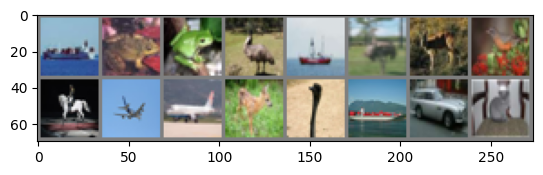

 ship frog frog bird ship bird deer birdhorseplaneplane deer bird ship  car  cat


In [3]:
import matplotlib.pyplot as plt
import numpy as np



def imshow(img):
    img = img /2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(''.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# CNN

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,32,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,64,5)
        self.fc1 = nn.Linear(64*5*5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
net = Net()

# Optimizer and Loss

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

# Train

In [6]:
epochs = 20

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
print('Model load into device:',device)

for epoch in range(epochs):
    running_loss = 0.0 
    for i, data in enumerate(trainloader, 0):
        # get the inputs, data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('Epoch %d , loss: %.3f' % 
                 (epoch +1, running_loss/2000))
            running_loss = 0.0
            
print('Finished Training')

Model load into device: cuda:0
Epoch 1 , loss: 1.529
Epoch 2 , loss: 1.093
Epoch 3 , loss: 0.950
Epoch 4 , loss: 0.856
Epoch 5 , loss: 0.776
Epoch 6 , loss: 0.718
Epoch 7 , loss: 0.671
Epoch 8 , loss: 0.622
Epoch 9 , loss: 0.579
Epoch 10 , loss: 0.542
Epoch 11 , loss: 0.504
Epoch 12 , loss: 0.474
Epoch 13 , loss: 0.434
Epoch 14 , loss: 0.408
Epoch 15 , loss: 0.381
Epoch 16 , loss: 0.364
Epoch 17 , loss: 0.337
Epoch 18 , loss: 0.321
Epoch 19 , loss: 0.293
Epoch 20 , loss: 0.286
Finished Training


# Evalutate

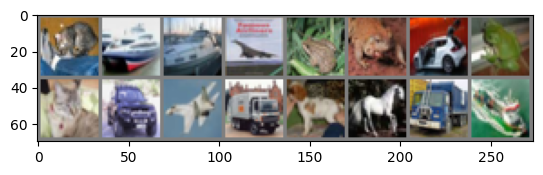

GroundTruth:   cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship


In [7]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: {}'.format(' '.join('%5s' % classes[labels[j]] for j in range(batch_size))))

In [8]:
net.to('cpu')
ouput = net(images)
_,  predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

Predicted:   deer   dog   car plane truck  bird  bird horse   cat  frog  ship   cat   dog   cat plane  bird


In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 69 %


In [10]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 78 %
Accuracy of  bird : 59 %
Accuracy of   cat : 54 %
Accuracy of  deer : 58 %
Accuracy of   dog : 59 %
Accuracy of  frog : 74 %
Accuracy of horse : 70 %
Accuracy of  ship : 77 %
Accuracy of truck : 80 %


# Train in GPU

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)